# DSMCER Notebook 11 - Neural Networks

1. Anatomy of a (basic) Neural Network
    1. Neurons, layers, networks
    2. Parameters of a Neuron, activation function
    3. _Poll_: Dimensionality of hidden layers
    4. _Poll_: Picking activation function
2. Backpropegation training
    1. The loss surface
    2. Training epochs, monitoring training
    3. _Poll_: Large vs small learning rate
    4. A basic example using very nonlinear features
    5. _Exercise_: Identify overfitting
    6. Batching
3. Some neural network hyperparameters
    1. The neurons
    2. Regularization hyperparameters
    3. Optimization hyperparameters
    4. _Poll_: Advantages and disadvantages of NNs

In [51]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

import sklearn.model_selection
import sklearn.preprocessing
import sklearn.decomposition

import rdkit.Chem
import rdkit.Chem.Descriptors
import rdkit.Chem.rdMolDescriptors
import rdkit.ML.Descriptors.MoleculeDescriptors

# ! NEW
import torch

***
***

## 1. Anatomy of a (basic) Neural Network

### A. Neurons, layers, networks

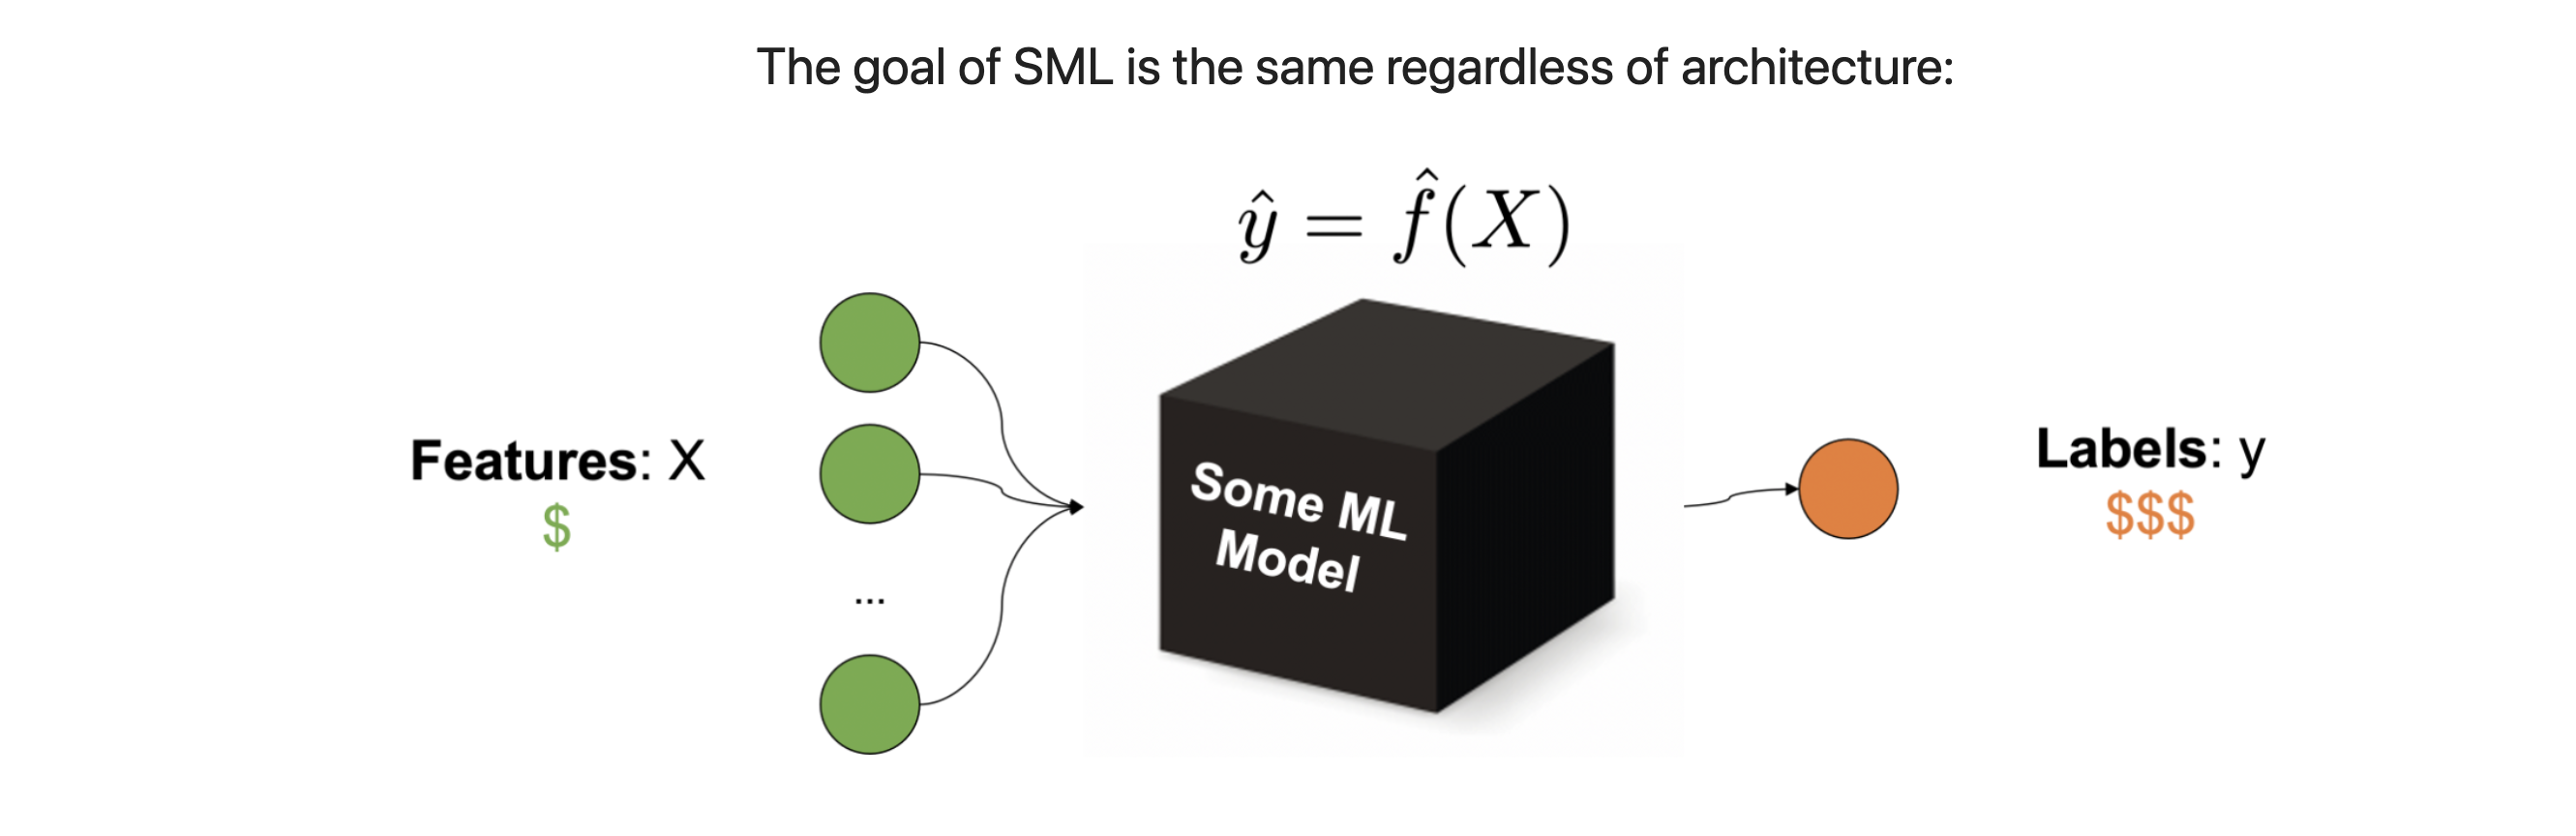

<font size=5><center> You may have heard of "Deep Learning" (eg. modeling with neural networks). __It is called deep because neural networks are highly nonlinear and extremely complex.__ They are made up of interconnected "neurons" stacked into "layers":

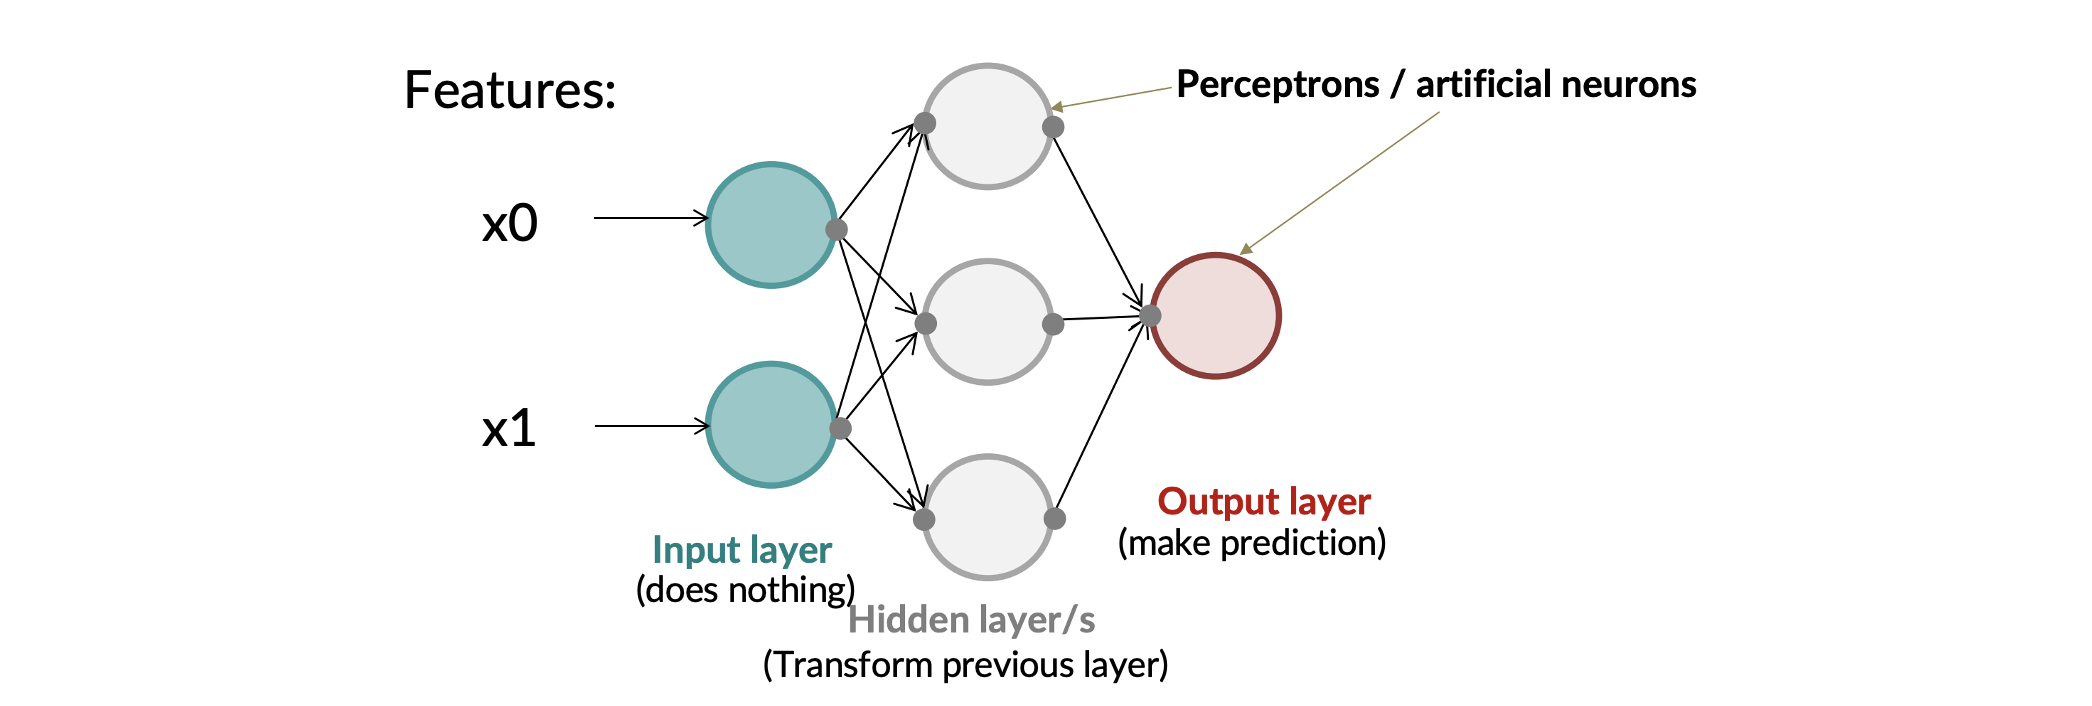

<font size=5><center>The data (X) __flows from left to right__ through the network (forward). At each step, mathematical transformations are conducted. The target is not involved yet (we will get to that).

***

<font size=4>So what are these "transformations"? Let's look at a single neuron:

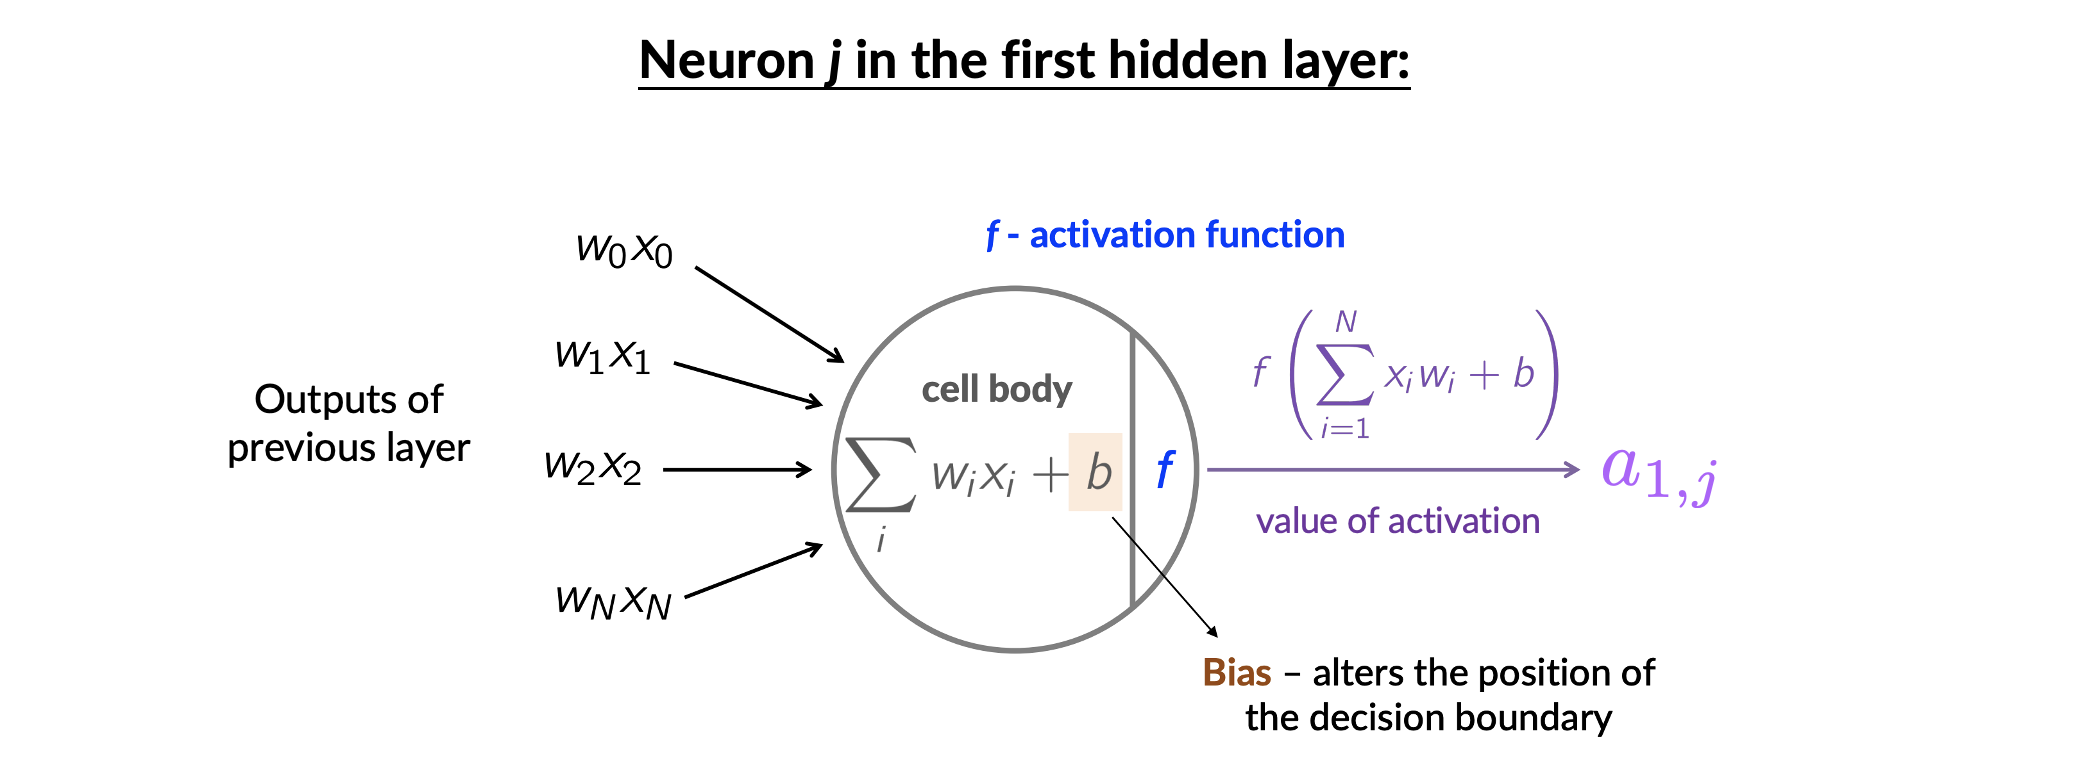

***

<font size=5><center>Activation functions are the source of the nonlinearity and happens as the last step of the neuron:

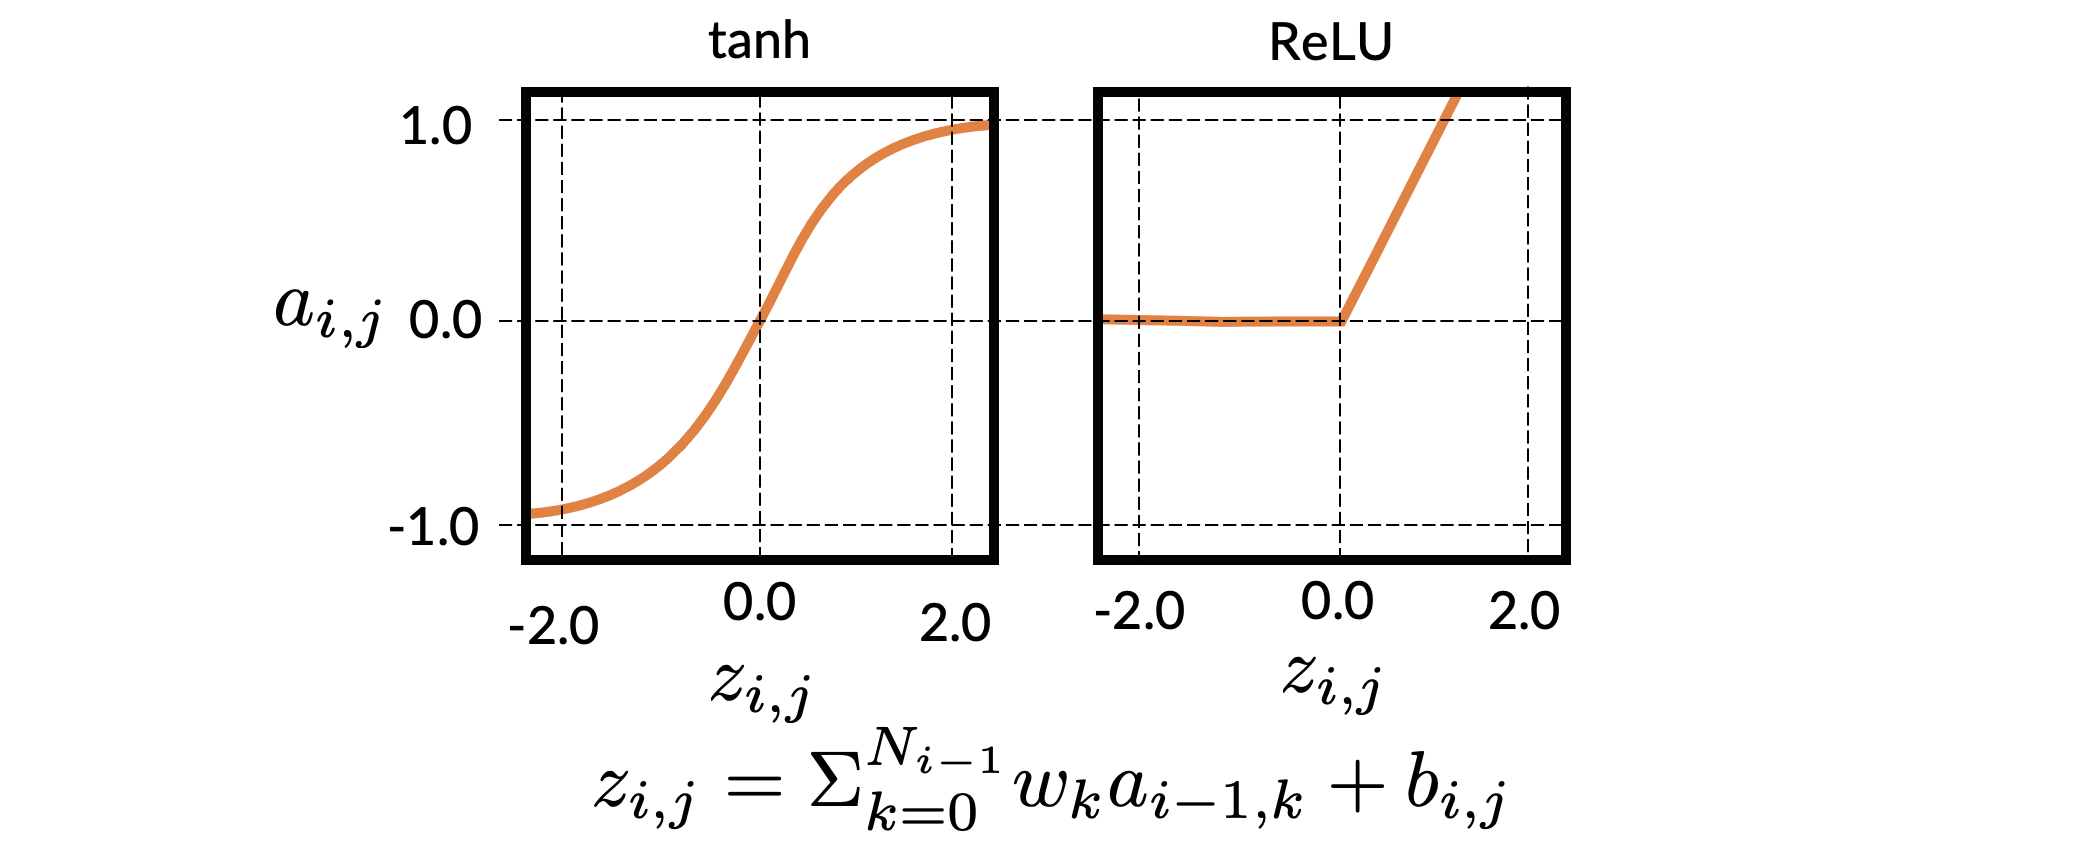

<font size=5><center>The activation function is a choice, there are many [options](https://www.analyticsvidhya.com/blog/2020/01/fundamentals-deep-learning-activation-functions-when-to-use-them/).

***

### B. _Poll_: Dimensionality of hidden layers

<font size=4> Here, we have 3 input features, eg. the dimensionality of our features is 3. What is the dimensionality of our third hidden layer?

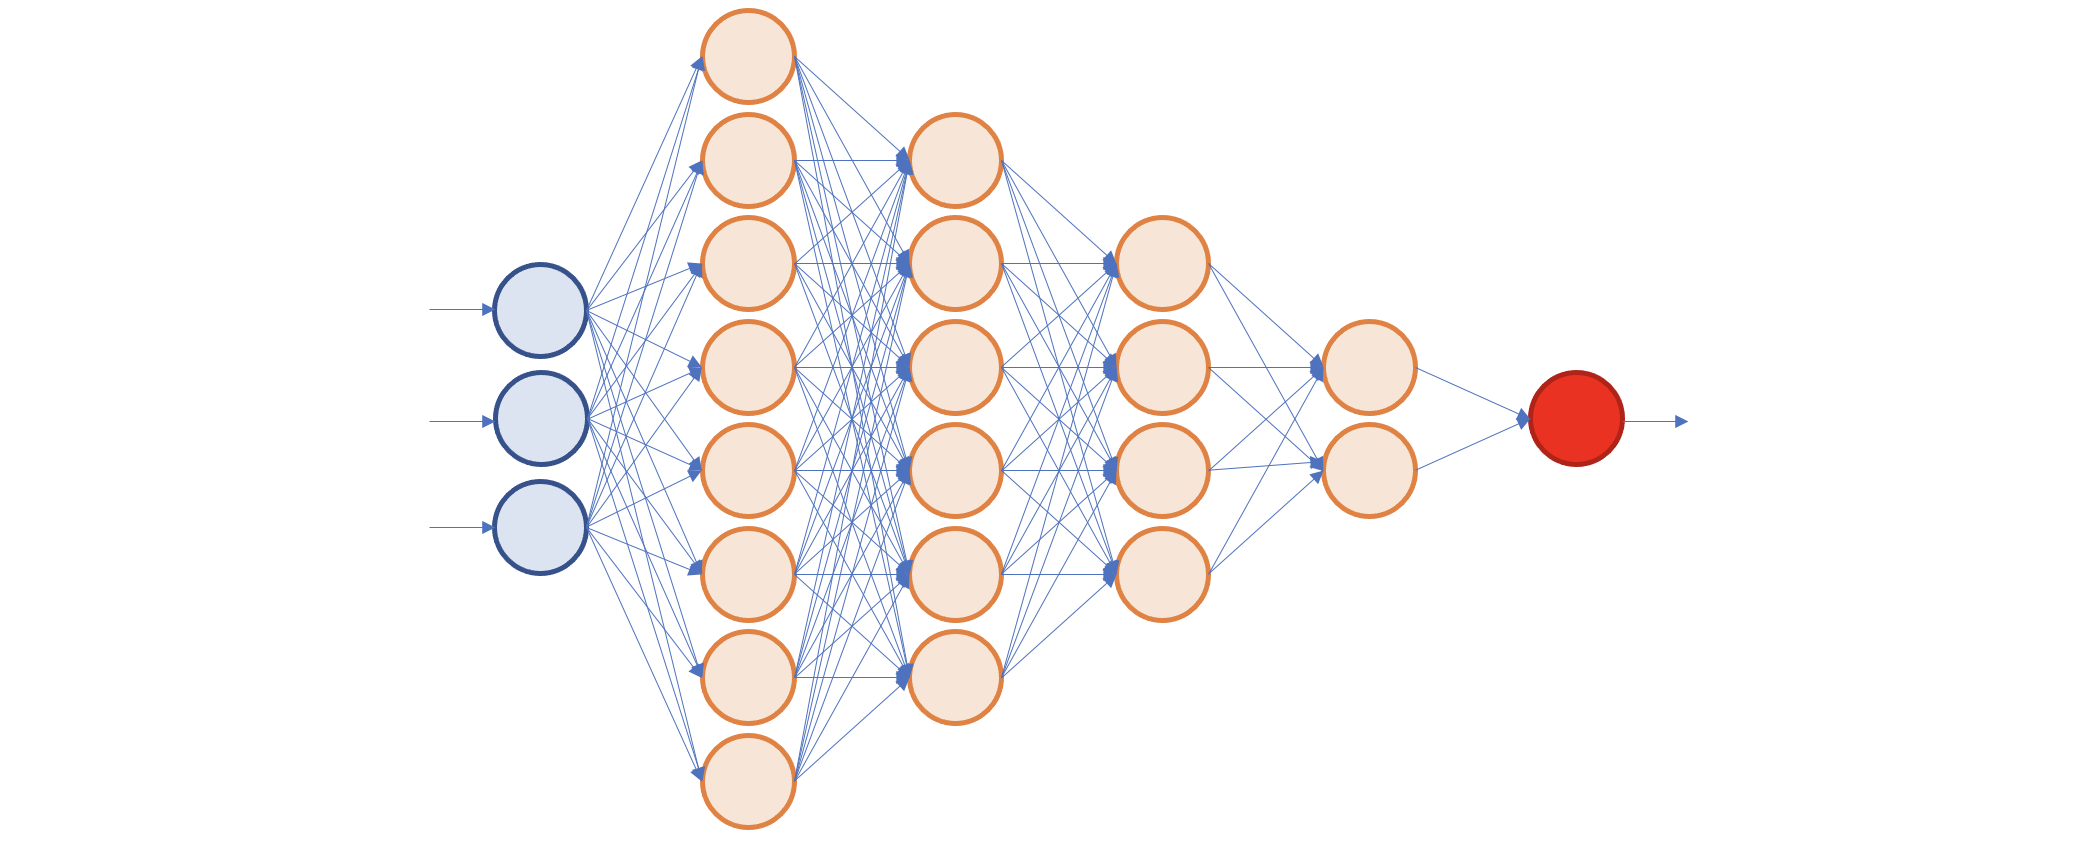

<font size=5><center>Each layer in the NN transforms the input into a new dimensional space.

***

<font size=5><center>The transformation of input to output then proceeds as follows:

1. <font size=4>__Every neuron__ in the first layer recieves __every feature__ and applies its own feature weights.
2. <font size=4>Each neuron sums the results, adds a bias, and passes the result though an activation function, producing __an activation for each neuron in the layer__. This vector of activations is often called the layer's hidden state, and has dimensions equal to the number of neurons in the kayer.
3. <font size=4>The second hidden layer recieves the first's activations, and __treats them exactly like the first treats features__.
4. <font size=4> __Repeat__ for each hidden layer.
5. <font size=4> The output layer works the same as the hidden layers, but __the number of neurons is equal to the dimensionality of the targets__, see the following table. Usually special activation functions are used on the output layer.

| Target | Output layer neuron count |
| ------ | ------------------------- |
| 1 regression target | 1 |
| binary classification | 1 |
| N-class classification (N>2) | N |
| N regression targets ("multitask model") | N |

***

### C. _Poll_: NN outputs

1. <font size=4> Consider the desired output of a classification problem (probability of each class). What characteristics of the activation function might we care about?(Min 0, Min -1, Max 0, Max 1, Sum 1, Sum 0)
    
2. <font size=4>For a regression task?

***

## 2. Backpropegation loss

### A. The loss surface

<font size=5><center>We know how the parameters transform the data from X input into target y prediction, __but how do we chose the parameter?__  Consider the mean squared error:

<font size=5>$$MSE = \frac{1}{M}\Sigma_i^M(y_i-\hat{y}_i)^2$$

<font size=5><center> For NNs, we have a very specific term called the __loss, that is just a chosen measure of error on the training data__.

<font size=4>For the sake of discussion, let's expand out model term:

<font size=5>$$\hat{y}_i = f(X_i;w_{0,0,0},...,w_{j,k,l}, b_{0,0}, ..., b_{j,k})$$

<font size=5><center> Our predictions are dependant on our parameters, __so our loss is dependant on our parameters__. This yield's a "loss surface"

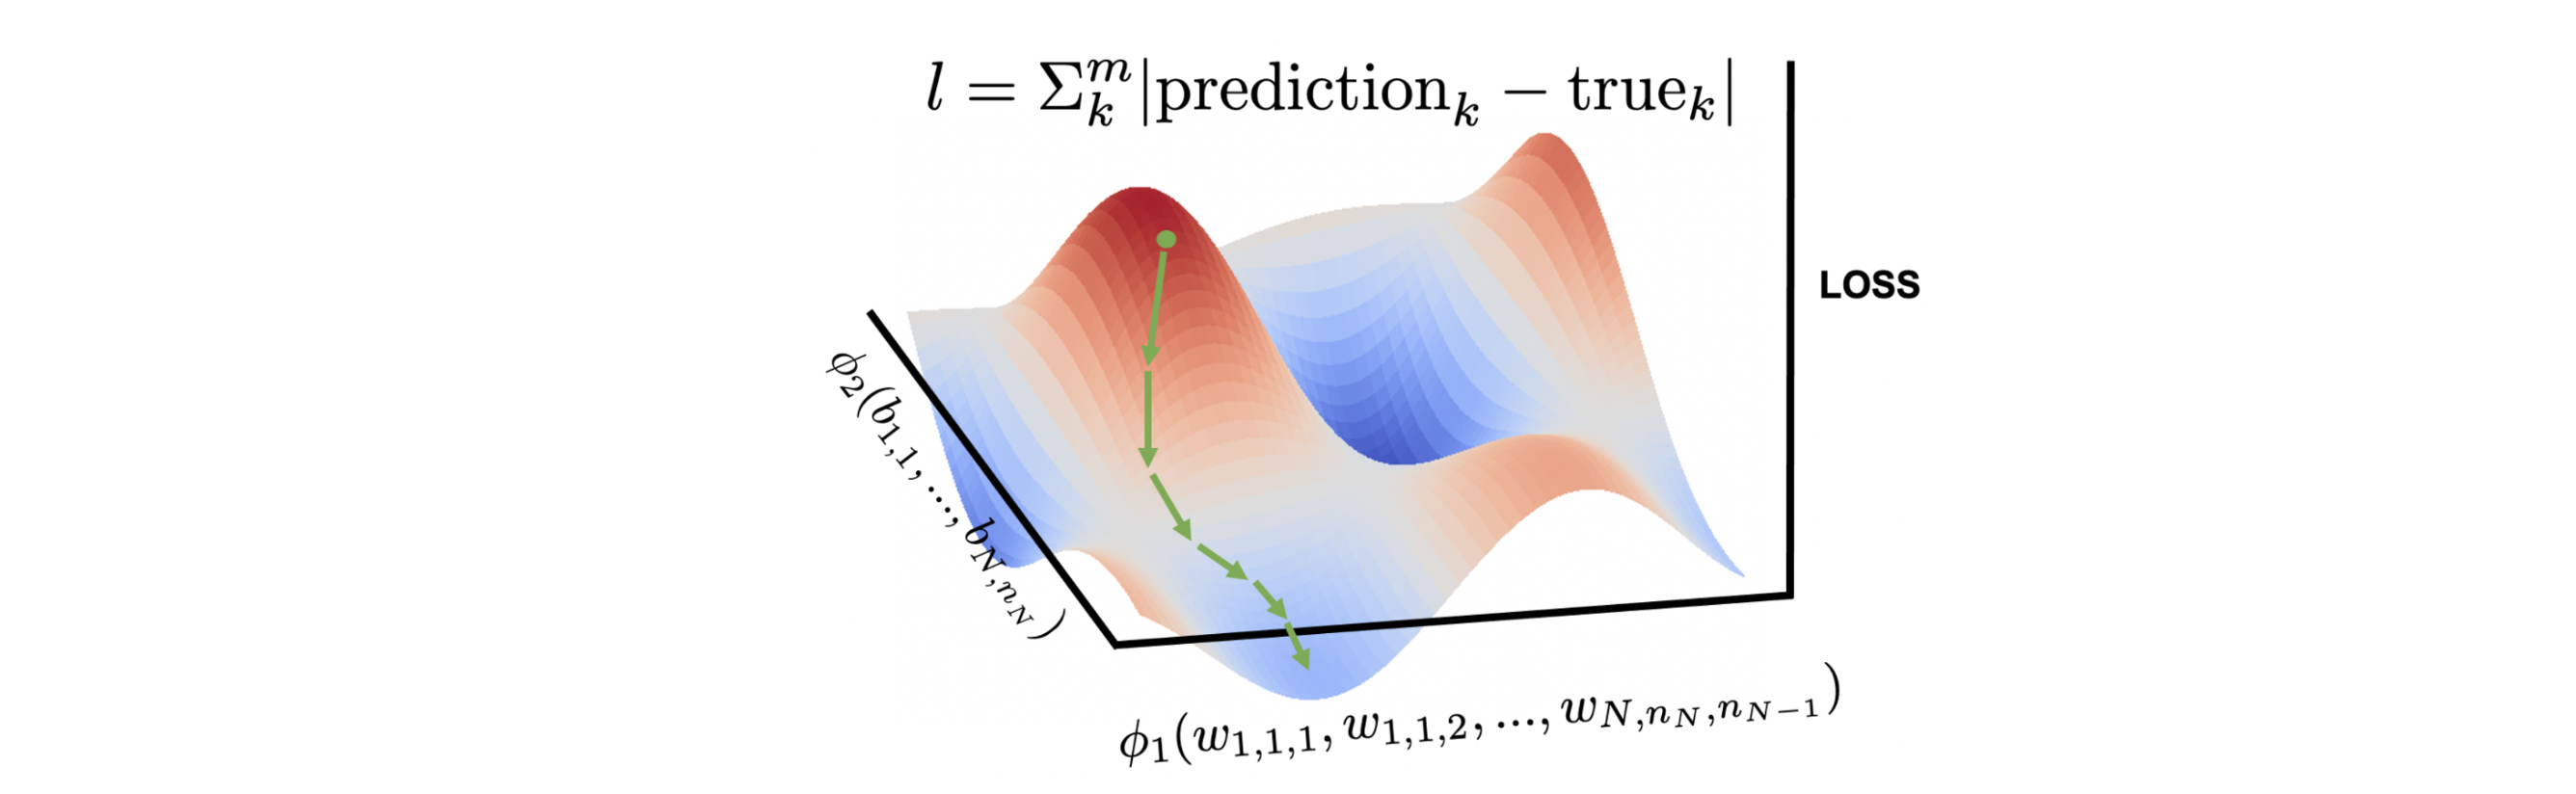

<font size=5><center> Our goal is to __change the parameters to minimize the loss__, and we can compute the loss for any set of parameters.

***

### B. Training epochs, monitoring training

<font size=5><center>__Critical__: While the optimum parameters (lowest loss) are __not__ analytical, the __derivative of the the loss with respect to the parameters *are*__. (As long as our activation functions are differentiable)

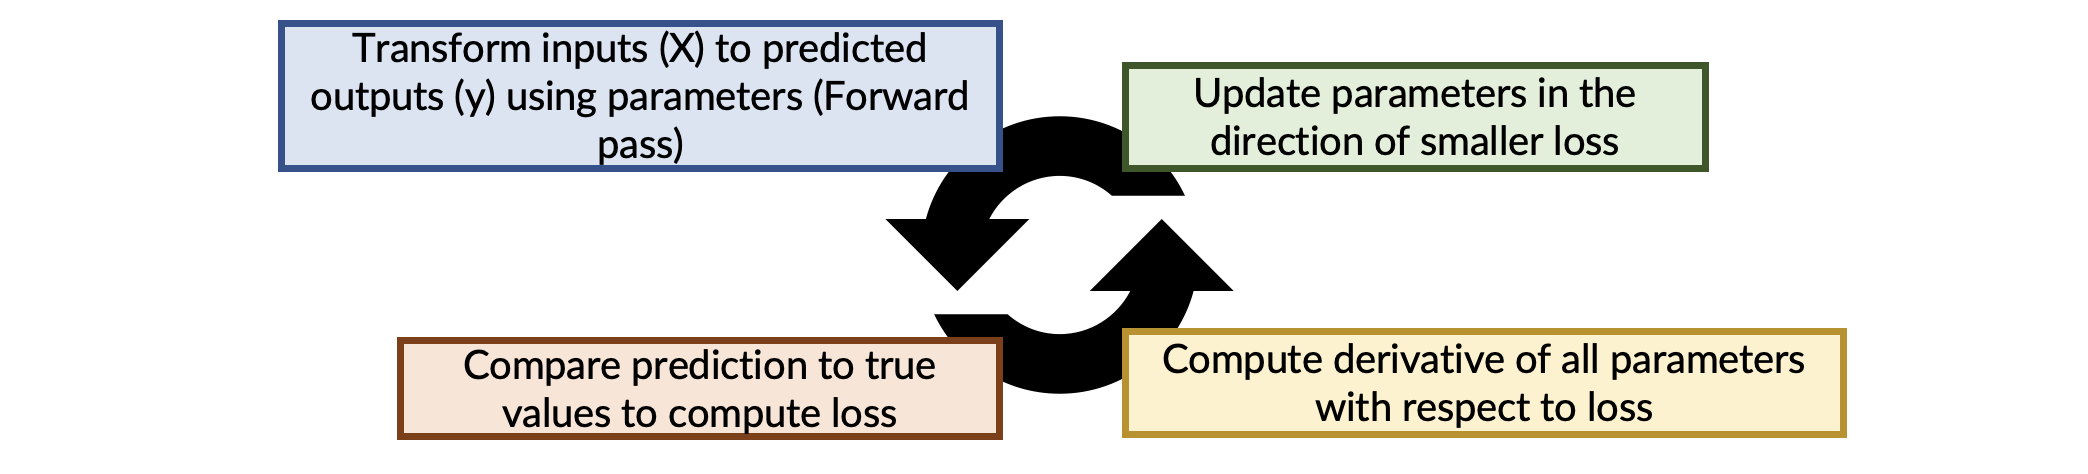

<font size=4>When we change the parameters in the direction of the gradient, we can take smaller, careful steps, or big ones. How much we move is dependant on what we call the __learning rate__:

<font size=5>$$p_{new} = p - \lambda \frac{dl}{dp}$$

<font size=4>$p$ is some parameter, $\lambda$ is the learning rate.

<font size=5><center>Every time we consider the whole training dataset to make parameter updates, this is called one __epoch__. Let me show you some pseudo code for the overall process:

In [2]:
"""
model = initialize_model()
learning_rate = 0.01

training_loss_history = []
validation_loss_history = []

for epoch in range(100):
    predictions = model.predict(train_X)
    train_loss = loss(train_y, predictions)
    val_loss = loss(val_y, model.predict(val_X))
    
    gradients = model.compute_gradients(train_loss)
    model.update_parameters(gradients, learning rate)
    
    training_loss_history.append(train_loss)
    validation_loss_history.append(val_loss)
"""

'\nmodel = initialize_model()\nlearning_rate = 0.01\n\ntraining_loss_history = []\nvalidation_loss_history = []\n\nfor epoch in range(100):\n    predictions = model.predict(train_X)\n    train_loss = loss(train_y, predictions)\n    val_loss = loss(val_y, model.predict(val_X))\n    \n    gradients = model.compute_gradients(train_loss)\n    model.update_parameters(gradients, learning rate)\n    \n    training_loss_history.append(train_loss)\n    validation_loss_history.append(val_loss)\n'

***

### C. _Poll_: Large vs small learning rate

<font size=4>What could go wrong if the learning rate is "too large"? What about "too small"?

***

### D. A worked example using very nonlinear features

<font size=5><center>Throughout the rest of the notebook I will point out some <span style="color:green">pros</span> of NNs and some <span style="color:orange">cons</span>...

<font size=4>Here we load the HCEPDB data, and we will regress the energy gap

In [4]:
df = pd.read_csv('http://faculty.washington.edu/dacb/HCEPDB_moldata.zip').sample(10000, random_state=1)

<font size=5><center><span style="color:green">NNs can leverage very large amounts of data because the can be made infinitely complex, HCEPDB is quite a large dataset, so an NN may be a good choice.

<font size=4>Let's extract the data

In [10]:
smiles = df['SMILES_str']

<font size=4>We will use rdkit to extract a new type of feature we haven't seen for molecules before called "[fingerprints](https://medium.com/@hacertilbec/introduction-to-cheminformatics-circular-fingerprints-f557cdc77492)." *If you are not going to be working to apply ML directly to molecular structure eg SMILES, don't worry too much about this* but basically fingerprints count up bonding patters in the structure like. One feature might be something like "count of oxygen two bonds away from nitrogen".

In [36]:
def get_fingerprint(smiles):
    mol = rdkit.Chem.MolFromSmiles(smiles)
    if mol == None:
        return None
    fp = rdkit.Chem.RDKFingerprint(mol)
    npfp = np.unpackbits(np.frombuffer(
        rdkit.DataStructs.BitVectToBinaryText(fp), dtype=np.uint8), bitorder='little')
    return npfp

In [37]:
fingerprints = smiles.apply(get_fingerprint)

[17:12:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10 11 12 13 15 16 17 18 19 20 21
[17:12:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 9 10 11 12 13 14 15 16 17 18 19 20 21 22
[17:12:26] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 10 12 13 14 15 16 17 18 19 20 21 22 24 25
[17:12:26] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 9 10 11 12 13 14 15 16 17 18 19 20 21 22 24 25
[17:12:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12 14 15 16 17 18 20 21 22
[17:12:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 7 8 9 10 11 12 13 14 15 16 17 18
[17:12:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8 9 10 11 12 13 14 15 16 17 18
[17:12:27] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
[17:12:29] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 21 22
[17:12:29] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 

<font size=4>Did we fail to compute features for any?

In [39]:
fingerprints.isna().mean()

0.0039

<font size=4>yes, for 0.3%. Drop them and get X and y

In [40]:
df['fps'] = fingerprints
print(f"Original amount of examples: {len(df)}")

Original amount of examples: 9961


In [41]:
df = df[~df['fps'].isna()]
print(f"Examples with successfully computed features: {len(df)}")

Examples with successfully computed features: 9961


In [42]:
X = np.vstack(df['fps'].values)
y = df['e_gap_alpha'].values.reshape(-1,1)

In [43]:
print(f"Shape of X: {X.shape}")

Shape of X: (9961, 2048)


<font size=4>The fingerprint has a lot of features... what do they look like?

In [49]:
X[0,:]

array([1, 1, 0, ..., 0, 1, 1], dtype=uint8)

<font size=4>So they are just zeros and ones... these features __are no longer physically interpretable quantities like descriptors eg. molar mass__.

<font size=5><center><span style="color:green">NNs are very good at working with complex, highly nonlinear, non-human readable features.

<font size=4>For giggles, lets PCA this and see how much we can reduce the dimensions...

In [54]:
pca = sklearn.decomposition.PCA(100)
pca.fit(X)

PCA(n_components=100)

In [57]:
np.cumsum(pca.explained_variance_ratio_)[-1]

0.6600814757442585

<font size=4>Even with __100 components we only explain 66% if the variance__. This indicates that the features are __not even close__ to linearly related to eachother, so our NN (very non linear) is a good choice for this kind of feature.

***

<font size=4>Typical preprocessing

In [59]:
dev_X, test_X, dev_y, test_y = sklearn.model_selection.train_test_split(X, y, test_size=0.15, random_state=42)
train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(dev_X, dev_y, test_size=0.15, random_state=42)

In [62]:
np.unique(dev_X)

array([0, 1], dtype=uint8)

<font size=4>Data are nominal, eg. bits. No need for standardization

***